# Import packages

In [ ]:
# !pip install -r multiff_analysis/requirements.txt

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

project_folder = '/Users/dusiyi/Documents/Multifirefly-Project'
os.chdir(project_folder)
sys.path.append(os.path.join(project_folder, 'multiff_analysis', 'methods'))

from non_behavioral_analysis.neural_data_analysis.model_neural_data import neural_data_modeling
from non_behavioral_analysis.neural_data_analysis.model_neural_data.cca_methods import cca_class, cca_utils, cca_lag_vs_no_lag_plotting, cca_cv_utils, cca_cv_plotting
from non_behavioral_analysis.neural_data_analysis.decode_targets import decode_target_class

import sys

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

# Machine Learning imports
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from statsmodels.multivariate.cancorr import CanCorr

# Neuroscience specific imports
import rcca

# To fit gpfa
import numpy as np
import neo
import matplotlib.pyplot as plt
from importlib import reload

plt.rcParams["animation.html"] = "html5"
os.environ['KMP_DUPLICATE_LIB_OK']='True'
rc('animation', html='jshtml')
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['animation.embed_limit'] = 2**128
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
print("done")


pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)


%load_ext autoreload
%autoreload 2

done
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get data

In [3]:
#raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Schro/data_0416"
raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0328"
dec = decode_target_class.DecodeTargetClass(raw_data_folder_path=raw_data_folder_path,
                                                               bin_width=0.02, window_width=0.05)

dec.get_x_and_y_var(exists_ok=False)
dec.reduce_y_var_lags(exists_ok=False)

Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Bruno/data_0328/ff_dataframe.h5
Retrieved target_df
Loaded behav_data_all from all_monkey_data/decoding_targets/monkey_Bruno/data_0328/behav_data_all.csv
Loaded single_vis_target_df from all_monkey_data/decoding_targets/monkey_Bruno/data_0328/single_vis_target_df.csv
8697 rows of 38676 rows (22.5%) of behav_data_all are preserved after taking out chunks between target last-seen time and capture time
0 segments (0.0%) out of 781 segments have 0 duration. They are dropped from pursuit data

No NA values found in pursuit_data
Window width changed from 0.05 to 0.06 to make it odd
Loaded binned_spikes_df from all_monkey_data/processed_neural_data/monkey_Bruno/data_0328/binned_spikes_df.csv
Saved x_var to all_monkey_data/decoding_targets/monkey_Bruno/data

In [5]:
cca_no_lag = cca_class.CCAclass(X1=dec.x_var, X2=dec.y_var_reduced, lagging_included=False)
cca_no_lag.conduct_cca()

cca_lags = cca_class.CCAclass(X1=dec.x_var_lags.drop(columns='bin'), X2=dec.y_var_lags_reduced, lagging_included=True)

# for all columns that end with _0, rename them to the column name without the _0
cca_lags.X2.columns = cca_lags.X2.columns.str.replace('_0', '')

print(f'dec.x_var_lags.shape: {dec.x_var_lags.shape}')
print(f'dec.y_var_lags_reduced.shape: {dec.y_var_lags_reduced.shape}')
cca_lags.conduct_cca()

cca_inst = cca_lags

Training CCA, kernel = None, regularization = 0.0000, 10 components


LinAlgError: The leading minor of order 3 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.

# CCA

https://medium.com/@pozdrawiamzuzanna/canonical-correlation-analysis-simple-explanation-and-python-example-a5b8e97648d2

## compare lag vs no lag

In [9]:
canon_df = pd.DataFrame(cca_inst.canon_corr, columns = ['no_lag'])
canon_df[f'with_lags'] = cca_lags.canon_corr
canon_df['component'] = [f'CC {i+1}' for i in range(cca_lags.n_components)]
# convert canon_df to long format
canon_df_long = pd.melt(canon_df, id_vars=['component'], var_name='lag', value_name='canon_coeff')

In [ ]:
# make a sns bar plot on canon_df_long
plt.figure(figsize=(8, 6))
sns.barplot(x='component', y='canon_coeff', data=canon_df_long, hue='lag')
plt.show()

## cca_inst (choose one between lags and no lag)

In [11]:
# choose no lag
cca_inst = cca_inst

In [12]:
# choose lags
cca_inst = cca_lags

## loadings

### neurons

In [ ]:
cca_inst.plot_ranked_loadings(X1_or_X2='X1', squared=False)

### behavior

In [ ]:
cca_inst.plot_ranked_loadings(X1_or_X2='X2', squared=False)

## squared loadings

### neurons

In [ ]:
cca_inst.plot_ranked_loadings(X1_or_X2='X1')

### behavior

In [ ]:
cca_inst.plot_ranked_loadings(X1_or_X2='X2')

## abs weights ranked

### neurons

In [ ]:
cca_inst.plot_ranked_weights()

### behavior

In [ ]:
cca_inst.plot_ranked_weights(X1_or_X2='X2')

## plot real weights

### neurons

In [ ]:
cca_inst.plot_ranked_weights(abs_value=False)

### behavior

In [ ]:
cca_inst.plot_ranked_weights(X1_or_X2='X2', abs_value=False)

In [ ]:
stop here!

## distribution of each feature

In [ ]:
cca_inst.X2_sc.shape

In [ ]:
X2_sc_df = pd.DataFrame(cca_inst.X2_sc, columns = cca_inst.X2.columns)
X2_sc_df.describe()

In [ ]:
for column in X2_sc_df.columns:
    plt.figure(figsize=(8, 2))
    sns.boxplot(X2_sc_df[column], orient='h')
    plt.show()
    

## heatmap of weights
Note: raw canonical coefficients are interpreted in a manner analogous to interpreting regression coefficients. For example: a one unit increase in reading leads to a .0446 decrease in the first canonical variate of set 2 when all of the other variables are held constant (in some other data)

In [ ]:
weight_df = cca_inst.X2_weight_df.copy()
weight_df = weight_df.set_index('feature').drop(columns='feature_category')

In [ ]:
plt.subplots(figsize=(15, 25))
sns.heatmap(weight_df.iloc[:20, :10], cmap='coolwarm', annot=True, linewidths=1)
plt.show()

## test for p values

In [ ]:
stats_cca = CanCorr(cca_inst.X1_sc, cca_inst.X2_sc)
print(stats_cca.corr_test().summary())
neural_data_modeling.print_weights('X', stats_cca.x_cancoef)
neural_data_modeling.print_weights('Z', stats_cca.y_cancoef)

## compute explained variance

In [ ]:
cca2.compute_ev([test1, test2])

In [ ]:
stop pls

# train test split

## no lag

In [ ]:
train1, test1, train2, test2 = train_test_split(cca_inst.X1_sc, cca_inst.X2_sc, test_size=0.3, random_state=42)
# use training and testing set
nComponents = 10
cca2 = rcca.CCA(kernelcca = False, reg = 0.1, numCC = nComponents)
cca2.train([train1, train2])

cca_inst.traincorrs = cca2.validate([train1, train2])
cca_inst.testcorrs = cca2.validate([test1, test2])

cca_utils.plot_cca_prediction_accuracy_train_test_bars(cca_inst.traincorrs, cca_inst.testcorrs)
cca_utils.plot_cca_prediction_accuracy_train_test_stacked_bars(cca_inst.traincorrs, cca_inst.testcorrs)
cca_utils.plot_cca_prediction_accuracy_test_w_bars(cca_inst.traincorrs)
cca_utils.plot_cca_prediction_accuracy_w_scatter(cca_inst.testcorrs)

In [ ]:
from cca_zoo.models import SCCA

ModuleNotFoundError: No module named 'cca_zoo.models'

## w lags

In [ ]:
train1, test1, train2, test2 = train_test_split(cca_lags.X1_sc, cca_lags.X2_sc, test_size=0.3, random_state=42)
# use training and testing set
nComponents = 10
cca2 = rcca.CCA(kernelcca = False, reg = 0., numCC = nComponents)
cca2.train([train1, train2])

cca_lags.traincorrs = cca2.validate([train1, train2])
cca_lags.testcorrs = cca2.validate([test1, test2])

cca_utils.plot_cca_prediction_accuracy_train_test_bars(cca_lags.traincorrs, cca_lags.testcorrs)
cca_utils.plot_cca_prediction_accuracy_train_test_stacked_bars(cca_lags.traincorrs, cca_lags.testcorrs)
cca_utils.plot_cca_prediction_accuracy_test_w_bars(cca_lags.traincorrs)
cca_utils.plot_cca_prediction_accuracy_w_scatter(cca_lags.testcorrs)

## compare lags vs no lag

In [23]:
def plot_cca_prediction_accuracy_train_test_bars_for_lags_and_no_lags(lags_testcorrs, lags_traincorrs, no_lags_testcorrs, no_lags_traincorrs):
    for i in range(2):
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(lags_testcorrs[i])), lags_testcorrs[i], alpha=0.3, label='Test with lags')
        plt.bar(range(len(no_lags_testcorrs[i])), no_lags_testcorrs[i], alpha=0.3, label='Test without lags')
        plt.xlabel('Canonical component index')
        plt.ylabel('Prediction correlation')
        plt.title(f'Test prediction accuracy for set {i+1}')
        plt.legend()
        plt.show()


        plt.figure(figsize=(10, 6))
        plt.bar(range(len(lags_traincorrs[i])), lags_traincorrs[i], alpha=0.3, label='Train with lags')
        plt.bar(range(len(no_lags_traincorrs[i])), no_lags_traincorrs[i], alpha=0.3, label='Train without lags')
        plt.xlabel('Canonical component index')
        plt.ylabel('Prediction correlation')
        plt.title(f'Test prediction accuracy for set {i+1}')
        plt.legend()
        plt.show()

In [ ]:
cca_lag_vs_no_lag_plotting.plot_cca_prediction_accuracy_train_test_bars_for_lags_and_no_lags(cca_lags.traincorrs, cca_lags.testcorrs, cca_inst.traincorrs, cca_inst.testcorrs)

## refactored more

In [193]:
combined_X1_df, combined_X2_df = cca_lag_vs_no_lag_plotting.combine_data_to_compare_train_and_test(cca_inst, cca_lags)

In [ ]:
cca_lag_vs_no_lag_plotting.plot_lag_offset_train_test_overlap(combined_X2_df, 'DatasetName', mode='lag_offset')


In [ ]:
cca_lag_vs_no_lag_plotting.plot_lag_offset_train_test_overlap(combined_X2_df, 'DatasetName', mode='train_offset')


# CV

## transform vars

In [16]:
cca_no_lag.X2_tf_df = cca_utils.transform_behav_data(cca_no_lag.X2)

cca_lags.X2_tf_df = cca_utils.transform_behav_data(cca_lags.X2)



In [17]:
cca_inst = cca_lags

X1_df = cca_inst.X1_sc_df
X2_df = cca_inst.X2_tf_df

x1_labels = X1_df.columns.values
x2_labels = X2_df.columns.values

X1 = X1_df.values
X2 = X2_df.values


In [7]:
X2_df.columns[-20:]

Index(['target_index', 'target_x', 'target_y', 'smooth_5_monkey_dw',
       'smooth_5_target_rel_x', 'smooth_7_monkey_dw', 'smooth_7_target_rel_x',
       'gaussian_smooth_2_monkey_ddv', 'gaussian_smooth_2_delta_distance',
       'gaussian_smooth_4_monkey_ddv', 'gaussian_smooth_4_delta_distance',
       'log_time_since_last_capture', 'poly_p0_5_monkey_ddv',
       'poly_p0_5_target_rel_y', 'poly_p1_monkey_ddv', 'poly_p1_target_rel_y',
       'poly_p2_monkey_ddv', 'poly_p2_target_rel_y', 'poly_p3_monkey_ddv',
       'poly_p3_target_rel_y'],
      dtype='object')

## run

In [ ]:
n_splits = 5
reg = 0.1
n_components = 10

# Canonical correlations
canon_corr_stats, cross_view_corr_stats = cca_cv_utils.crossvalidated_cca_analysis(X1, X2, n_components=n_components, reg=reg, n_splits=n_splits)


Training CCA, kernel = None, regularization = 0.1000, 10 components


/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Training CCA, kernel = None, regularization = 0.1000, 10 components
Training CCA, kernel = None, regularization = 0.1000, 10 components
Training CCA, kernel = None, regularization = 0.1000, 10 components
Training CCA, kernel = None, regularization = 0.1000, 10 components


## plot

### cross view

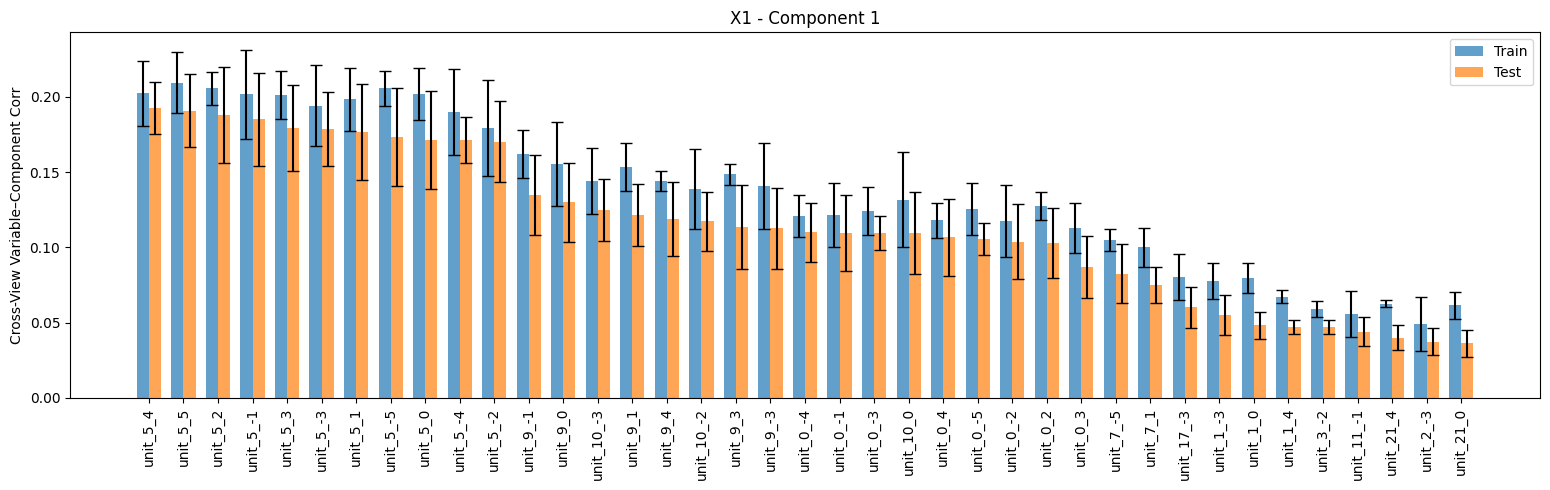

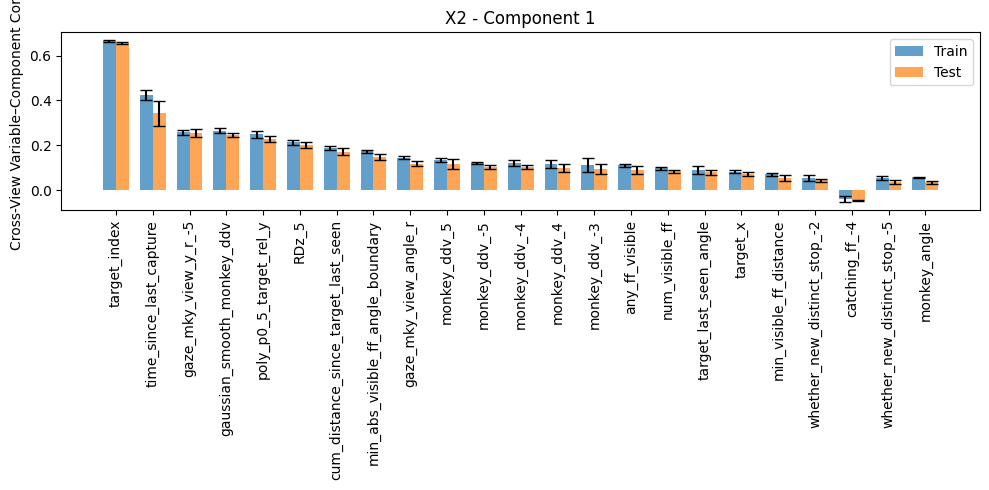

In [ ]:
use_cross_view_corr = True
filter_significant = True
sort_by_significance = True
significance_threshold = 4

# Full plot
cca_cv_plotting.plot_cca_cv_results(cross_view_corr_stats, x1_labels, data_type='X1', component=0, use_cross_view_corr=use_cross_view_corr,
                                    filter_significant=filter_significant, sort_by_significance=sort_by_significance, significance_threshold=significance_threshold)
# Canonical correlation view
cca_cv_plotting.plot_cca_cv_results(cross_view_corr_stats, x2_labels, data_type='X2', component=0, use_cross_view_corr=use_cross_view_corr,
                                    filter_significant=filter_significant, sort_by_significance=sort_by_significance, significance_threshold=significance_threshold)


### canon corr

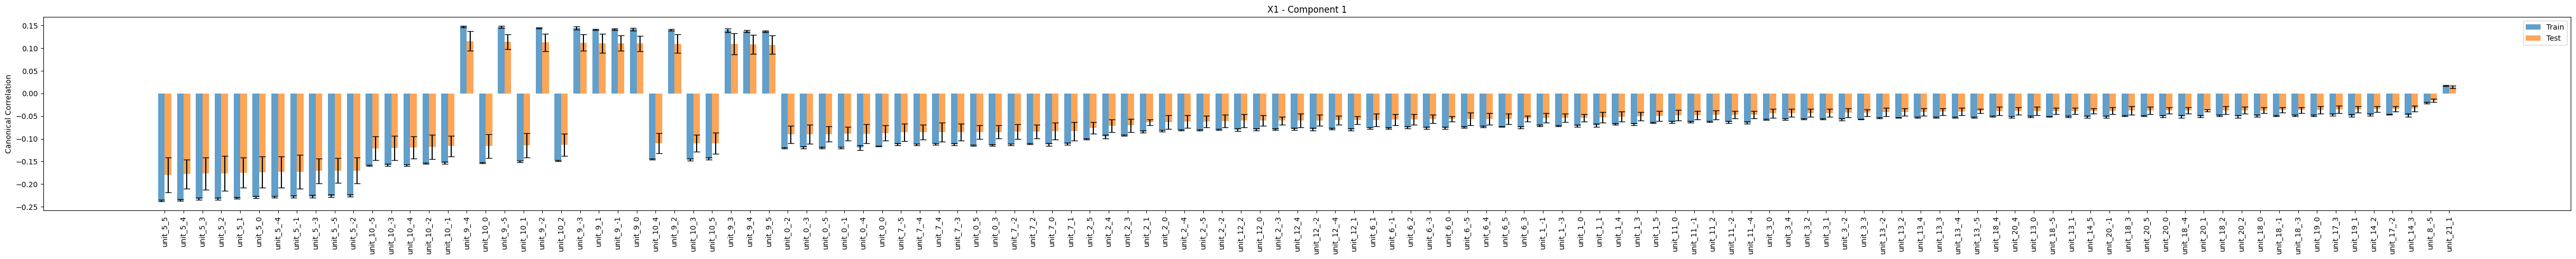

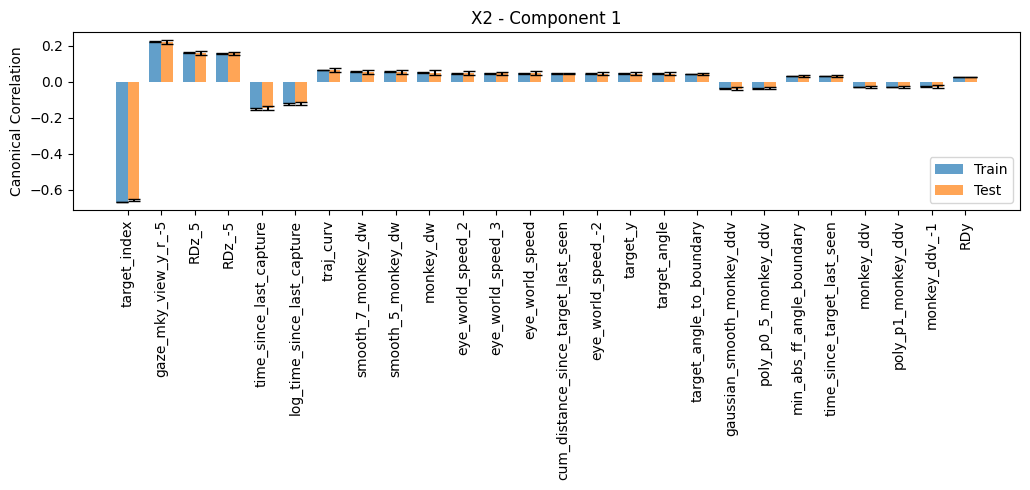

In [ ]:
use_cross_view_corr = False
filter_significant = True
sort_by_significance = True
significance_threshold = 4

# Full plot
cca_cv_plotting.plot_cca_cv_results(canon_corr_stats, x1_labels, data_type='X1', component=0, use_cross_view_corr=use_cross_view_corr,
                                    filter_significant=filter_significant, sort_by_significance=sort_by_significance, significance_threshold=significance_threshold)
# Canonical correlation view
cca_cv_plotting.plot_cca_cv_results(canon_corr_stats, x2_labels, data_type='X2', component=0, use_cross_view_corr=use_cross_view_corr,
                                    filter_significant=filter_significant, sort_by_significance=sort_by_significance, significance_threshold=significance_threshold)


# potential transformers to use

In [ ]:
transformers = [
    ('identity', lambda x: x),
    ('log_signed', lambda x: np.log1p(np.abs(x)) * np.sign(x)),
    ('poly', lambda x: np.hstack([x**p for p in [1, 2, 3]])),
    ('sqrt_signed', lambda x: np.sqrt(np.abs(x)) * np.sign(x)),
    ('rank_gauss', rank_gauss_transform)  # optional custom
]


# check NA

In [60]:
general_utils.find_rows_with_na(cca_inst.X2_sc_df)


No NA values found in DataFrame


(Empty DataFrame
 Columns: [monkey_angle_0, monkey_dw_0, monkey_ddw_0, monkey_ddv_0, whether_new_distinct_stop_0, delta_distance_0, RDy_0, gaze_mky_view_y_r_0, gaze_mky_view_angle_r_0, eye_world_speed_0, num_visible_ff_0, min_abs_ff_angle_boundary_0, min_visible_ff_distance_0, min_abs_visible_ff_angle_boundary_0, catching_ff_0, any_ff_visible_0, time_since_last_capture_0, traj_curv_0, gaze_world_y_l_0, monkey_ddw_-1, monkey_ddv_-1, whether_new_distinct_stop_-1, delta_distance_-1, eye_world_speed_-1, catching_ff_-1, gaze_world_y_l_-1, monkey_ddw_1, monkey_ddv_1, whether_new_distinct_stop_1, delta_distance_1, gaze_mky_view_y_r_1, eye_world_speed_1, catching_ff_1, gaze_world_y_l_1, monkey_ddw_-2, monkey_ddv_-2, whether_new_distinct_stop_-2, delta_distance_-2, gaze_mky_view_x_r_-2, eye_world_speed_-2, catching_ff_-2, gaze_world_y_l_-2, monkey_ddw_2, monkey_ddv_2, whether_new_distinct_stop_2, delta_distance_2, gaze_mky_view_y_r_2, eye_world_speed_2, catching_ff_2, gaze_world_y_l_2, monkey_d

In [ ]:
general_utils.check_array_integrity(X_t, name="Array", top_n=10, verbose=True)


=== Checking: Array ===
Shape: (33125, 124)
❗ Total NaN values: 25808 (0.6283%)
Rows with ≥1 NaN: 21305
Cols with ≥1 NaN: 2
First 10 NaN positions (row, col): [(10, 115), (11, 115), (12, 115), (31, 115), (32, 115), (33, 115), (34, 115), (35, 115), (36, 115), (37, 115)]
Columns with most NaNs:
  Column 116: 16680 NaNs
  Column 115: 9128 NaNs
Rows with most NaNs:
  Row 13967: 2 NaNs
  Row 17428: 2 NaNs
  Row 23344: 2 NaNs
  Row 12360: 2 NaNs
  Row 28610: 2 NaNs
  Row 28611: 2 NaNs
  Row 28612: 2 NaNs
  Row 28613: 2 NaNs
  Row 28614: 2 NaNs
  Row 28615: 2 NaNs
✅ No infinite values found.

--- Summary statistics (excluding NaNs) ---
Min: -226.208235
Max: 350.576906
Mean: 0.021387
Std: 1.965530


# permutation test (later)

In [ ]:
import numpy as np
from tqdm import tqdm

n_permutations = 1000
component = 0  # which canonical component
n_features = X1.shape[1]

# Store observed loadings
observed_loadings = mean_X1_test[:, component]  # or use your preferred estimate

# Store null distributions
null_loadings = np.zeros((n_features, n_permutations))

for perm in tqdm(range(n_permutations)):
    # Shuffle rows of X1
    X1_perm = np.random.permutation(X1)
    # Fit CCA on permuted X1 and original X2
    cca2 = rcca.CCA(kernelcca=False, reg=0.1, numCC=nComponents)
    cca2.train([X1_perm, X2])
    U_perm = np.dot(X1_perm, cca2.ws[0])
    # Compute loadings for permuted data
    load_X1_perm = np.corrcoef(X1_perm.T, U_perm.T)[:n_features, n_features:]
    null_loadings[:, perm] = load_X1_perm[:, component]

# Compute two-sided p-values
p_values = np.mean(np.abs(null_loadings) >= np.abs(observed_loadings[:, None]), axis=1)

In [ ]:
import matplotlib.pyplot as plt

alpha = 0.05  # significance level
significant_mask = p_values < alpha

sig_means = observed_loadings[significant_mask]
sig_stds = std_X1_test[significant_mask, component]  # or use std from CV
sig_labels = np.array(x1_labels)[significant_mask]

plt.figure(figsize=(12, 5))
plt.bar(sig_labels, sig_means, yerr=sig_stds, capsize=5, color='skyblue')
plt.xticks(rotation=90)
plt.ylabel('Mean Canonical Loading')
plt.title(f'Significant Canonical Loadings (p < {alpha})')
plt.tight_layout()
plt.show()

# Now: could you use neural data to decode target position?

what about 2nd target's position?
(can either use 1st target's decoder, or train and separate decoder for 2nd target)

also...try GPFA at some point 

# Appendix

## try different transformers

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.cross_decomposition import CCA

# Example feature functions
def power_features(X, powers=[1, 2, 3]):
    return np.hstack([np.power(X, p) for p in powers])

# Combine multiple transformer functions
transformers = [
    ('poly2', lambda x: power_features(x, powers=[1, 2])),
    ('log', lambda x: np.log1p(np.abs(x)) * np.sign(x))
]

# Applies all transformers and concatenates the result
def apply_transformers(X, transformers):
    transformed_parts = []
    for _, func in transformers:
        out = func(X)
        if out.ndim == 1:
            out = out[:, np.newaxis]
        transformed_parts.append(out)
    return np.hstack(transformed_parts)

# Input data
X1 = cca_inst.X1_sc
X2 = cca_inst.X2_sc

best_score = -np.inf
n_splits = 3
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

train_scores, test_scores = [], []

print(f"\n--- Evaluating combined transformed features: {', '.join(name for name, _ in transformers)} ---")

for fold_num, (train_idx, test_idx) in enumerate(kf.split(X1), 1):
    print(f" Fold {fold_num}/{n_splits}")
    X1_train, X1_test = X1[train_idx], X1[test_idx]
    X2_train, X2_test = X2[train_idx], X2[test_idx]

    # Apply all transformers to both datasets
    X1_train_t = apply_transformers(X1_train, transformers)
    X1_test_t = apply_transformers(X1_test, transformers)
    X2_train_t = apply_transformers(X2_train, transformers)
    X2_test_t = apply_transformers(X2_test, transformers)
    
    # print new
    print(f"X1_train_t shape: {X1_train_t.shape}")
    print(f"X1_test_t shape: {X1_test_t.shape}")
    print(f"X2_train_t shape: {X2_train_t.shape}")
    print(f"X2_test_t shape: {X2_test_t.shape}")

    # Fit CCA
    cca = CCA(n_components=2)
    cca.fit(X1_train_t, X2_train_t)

    # Project both sets
    X1_train_c, X2_train_c = cca.transform(X1_train_t, X2_train_t)
    X1_test_c, X2_test_c = cca.transform(X1_test_t, X2_test_t)

    # Mean correlation across components
    train_corr = np.mean([np.corrcoef(X1_train_c[:, i], X2_train_c[:, i])[0, 1] for i in range(2)])
    test_corr = np.mean([np.corrcoef(X1_test_c[:, i], X2_test_c[:, i])[0, 1] for i in range(2)])

    train_scores.append(train_corr)
    test_scores.append(test_corr)

# Final evaluation
mean_train = np.mean(train_scores)
mean_test = np.mean(test_scores)

print(f"\n✅ Combined Transform Results")
print(f" Mean train corr: {mean_train:.3f}")
print(f" Mean CV test corr: {mean_test:.3f}")


## ddv

In [ ]:
ddv_vars = [var for var in dec.y_var_lags if 'ddv' in var]
dec.y_var_lags[ddv_vars].corr()

,monkey_ddv_0,monkey_ddv_-1,monkey_ddv_1,monkey_ddv_-2,monkey_ddv_2,monkey_ddv_-3,monkey_ddv_3,monkey_ddv_-4,monkey_ddv_4,monkey_ddv_-5,monkey_ddv_5
monkey_ddv_0,1.00000,0.44819,0.44730,0.33022,0.33172,0.34251,0.36256,0.22721,0.25478,0.13250,0.16888
monkey_ddv_-1,0.44819,1.00000,0.33237,0.45076,0.35958,0.32786,0.25310,0.34147,0.16935,0.22420,0.09874
monkey_ddv_1,0.44730,0.33237,1.00000,0.34821,0.43215,0.23203,0.31133,0.14085,0.34788,0.06387,0.23817
monkey_ddv_-2,0.33022,0.45076,0.34821,1.00000,0.24171,0.45615,0.15910,0.33086,0.09159,0.34073,0.02593
monkey_ddv_2,0.33172,0.35958,0.43215,0.24171,1.00000,0.14855,0.40963,0.07346,0.28801,0.00418,0.32570
monkey_ddv_-3,0.34251,0.32786,0.23203,0.45615,0.14855,1.00000,0.08197,0.45819,0.01901,0.32947,-0.02680
monkey_ddv_3,0.36256,0.25310,0.31133,0.15910,0.40963,0.08197,1.00000,0.01258,0.38439,-0.03798,0.25839
monkey_ddv_-4,0.22721,0.34147,0.14085,0.33086,0.07346,0.45819,0.01258,1.00000,-0.03071,0.45591,-0.06499
monkey_ddv_4,0.25478,0.16935,0.34788,0.09159,0.28801,0.01901,0.38439,-0.03071,1.00000,-0.07027,0.36550
monkey_ddv_-5,0.13250,0.22420,0.06387,0.34073,0.00418,0.32947,-0.03798,0.45591,-0.07027,1.00000,-0.09684
